## Abstract

This project applied Machine Learning and Linear Algebra techniques to support the insurance company "Protect Your Tomorrow" across four strategic fronts:

Customer Similarity: Identified similar clients using kNN to support targeted marketing strategies.

Benefit Prediction: Predicted the likelihood of new customers receiving insurance payments via a kNN classifier, significantly outperforming dummy baselines.

Claim Estimation: Estimated the number of insurance payments using a Linear Regression model implemented via a matrix-based analytical solution, achieving RMSE ≈ 0.34 and R² ≈ 0.66.

Data Privacy: Protected personal information using an invertible linear transformation, proving both analytically and computationally that data obfuscation does not degrade model performance.

The results demonstrate that it is possible to combine reliable predictive modeling with data protection, meeting both business requirements and privacy standards.


# Statement

The insurance company "Protect Your Tomorrow" aims to leverage Machine Learning to solve specific business challenges. The project involves evaluating the feasibility of the following tasks:

Task 1: Customer Similarity – Identify clients similar to a specific profile to assist the marketing team in targeted campaigns.

Task 2: Benefit Prediction – Develop a classification model to predict whether a new customer is likely to receive an insurance payment, ensuring it outperforms a dummy baseline.

Task 3: Claim Forecasting – Predict the expected number of insurance payments for new customers using a Linear Regression model.

Task 4: Data Privacy (Obfuscation) – Protect customers' personal data without compromising model performance. The goal is to develop a data transformation algorithm (masking/obfuscation) that prevents personal information recovery if the data is compromised, while maintaining the predictive quality of the models.

**Tarefa 1:**  
Foi possível implementar um algoritmo baseado em **kNN** que identifica os clientes mais próximos com base em características como idade, gênero, renda e número de familiares.  
- Observação: os dados precisam ser **escalados** para que todas as características tenham impacto equilibrado na distância.  
- Métrica de distância Euclidiana ou Manhattan pode ser usada, e ambas geram resultados coerentes.

**Tarefa 2:**  
Foi testado um **classificador kNN** e comparado com modelos dummy (aleatórios).  
- Resultado: o modelo kNN apresentou **F1 maior que os modelos dummy**, mostrando que é possível superar uma predição aleatória.  
- Conclusão: é viável prever se o cliente fará algum pagamento de seguro usando um modelo de aprendizado de máquina.

**Tarefa 3:**  
Foi utilizada **Regressão Linear** para prever o número de pagamentos:  
- Resultado: REQM ≈ 0.34 e R² ≈ 0.66 para os dados originais, indicando que o modelo captura boa parte da variabilidade dos dados.  
- Conclusão: a Regressão Linear é adequada para estimar a quantidade de pagamentos de seguro de um cliente.

**Tarefa 4:**  
Foi implementada uma **ofuscação linear** multiplicando a matriz de características por uma **matriz invertível**:  
- Resultado: as previsões e métricas da Regressão Linear **não mudaram**, confirmando que o modelo funciona com dados ofuscados.  
- Conclusão: é possível proteger informações pessoais dos clientes sem degradar a qualidade das previsões.


# Data Preprocessing & Exploration

## Initialization & Imports

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sklearn.linear_model
import sklearn.metrics
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from IPython.display import display

## Load Data

Carregue os dados e faça uma verificação básica de que estão livres de problemas óbvios.

In [38]:
df = pd.read_csv('../dataset/insurance_us.csv')

# Renaming columns for consistency
df = df.rename(columns={
    'Gender': 'gender',
    'Age': 'age',
    'Salary': 'income',
    'Family members': 'family_members',
    'Insurance benefits': 'insurance_benefits'
})

Renomeamos as colunas para tornar o código mais consistente com seu estilo.

In [39]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
400,1,26.0,39500.0,1,0
2253,1,53.0,29700.0,1,2
912,1,50.0,45400.0,0,2
3589,0,42.0,32800.0,1,1
4282,1,33.0,39300.0,1,0
1049,1,23.0,33100.0,1,0
1376,0,35.0,49100.0,2,0
1666,0,36.0,31700.0,1,0
3620,0,41.0,39800.0,1,0
19,1,27.0,36900.0,0,0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [41]:
# podemos querer corrigir o tipo de idade (de float para int), embora isso não seja crítico

# escreva sua conversão aqui se você escolher:

In [42]:
# verifique se a conversão foi bem-sucedida

In [43]:
# agora dê uma olhada nas estatísticas descritivas dos dados.
# Parece que está tudo bem?

Os dados estão limpos e prontos para uso. Porém como df.sample(10) exibiu, a Classe alvo (insurance_benefits) é desbalanceada: muitos zeros e poucos casos com >0.

In [44]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


## AED

Vamos verificar rapidamente se existem determinados grupos de clientes observando o gráfico de pares.

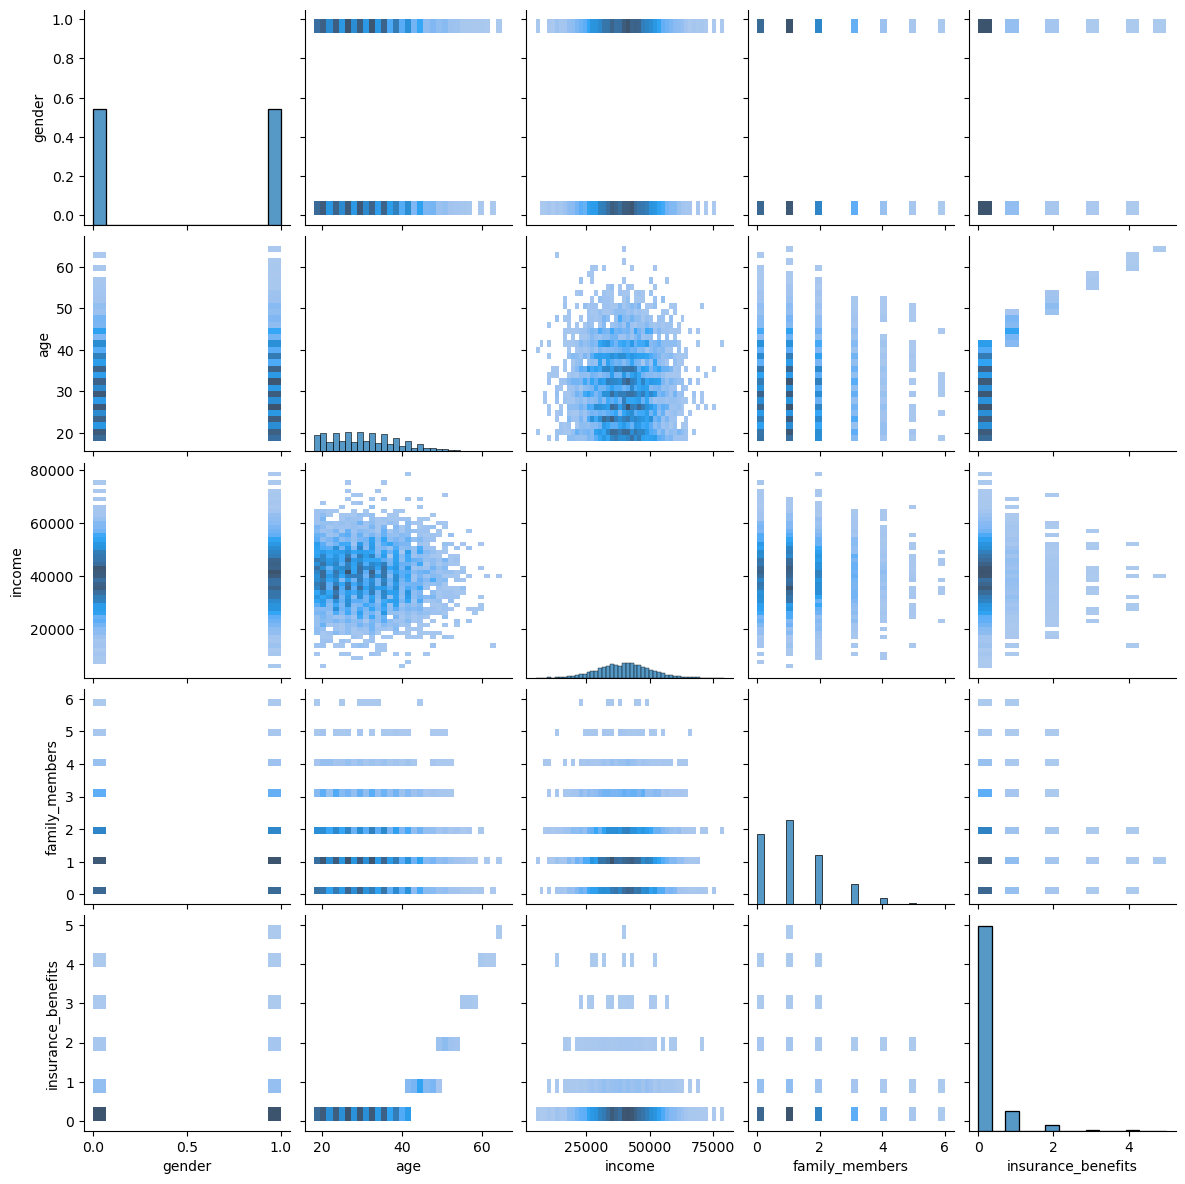

In [45]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, é um pouco difícil identificar grupos óbvios (clusters), pois é difícil combinar várias variáveis simultaneamente (para analisar distribuições multivariadas). É aí que Álgebra Linear e Aprendizado de Máquina podem ser bastante úteis.

# Tarefa 1. Clientes Similares

Na linguagem de AM, é necessário desenvolver um procedimento que retorne k vizinhos mais próximos (objetos) para um determinado objeto com base na distância entre os objetos.

Você pode querer rever as seguintes lições (capítulo -> lição)
- Distância Entre Vetores -> Distância Euclidiana
- Distância Entre Vetores -> Distância de Manhattan

Para resolver a tarefa, podemos tentar diferentes métricas de distância.

Escreva uma função que retorne k vizinhos mais próximos para um n-ésimo objeto com base em uma métrica de distância especificada. O número de pagamentos de seguro recebidos não deve ser levado em consideração para esta tarefa. 

Você pode usar uma implementação pronta do algoritmo kNN do scikit-learn (verifique [o link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) ou usar a sua própria.

Teste-o para quatro combinações de dois casos
- Escalabilidade
  - os dados não são escalados
  - os dados escalados com o escalonador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) 
- Métricas de distância
  - Euclidiana
  - Manhattan

Responda às perguntas:
- Os dados não escalados afetam o algoritmo kNN? Se sim, como isso acontece?
-Quão semelhantes são os resultados usando a métrica de distância de Manhattan (independentemente da escalabilidade)?

In [46]:
feature_names = ['gender', 'age', 'income', 'family_members']

def get_knn(df, n, k, metric):
    """
    Returns the k nearest neighbors.

    :param df: pandas DataFrame used to find similar objects
    :param n: object index for which neighbors are searched
    :param k: number of neighbors to return
    :param metric: distance metric name
    """
    nbrs = sklearn.neighbors.NearestNeighbors(metric=metric)
    nbrs.fit(df[feature_names])

    distances, indices = nbrs.kneighbors(
        [df.iloc[n][feature_names]],
        k,
        return_distance=True
    )

    df_res = pd.concat([
        df.iloc[indices[0]],
        pd.DataFrame(distances.T, index=indices[0], columns=['distance'])
    ], axis=1)

    return df_res

Escalando os dados

In [47]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())


/var/folders/jx/_q0hlhjj65zcpy3pb78x177w0000gq/T/ipykernel_32254/2861629551.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.16666667 0.16666667 0.         ... 0.33333333 0.5        0.16666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())


In [48]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1635,1,0.323077,0.570886,0.500000,0
2113,0,0.461538,0.665823,0.333333,0
2610,1,0.738462,0.731646,0.000000,1
3737,1,0.538462,0.482278,0.166667,0
2619,0,0.492308,0.497468,0.166667,0


Agora, vamos obter registros semelhantes para um determinado registro para cada combinação

In [49]:
print("Unscaled – Euclidean")
display(get_knn(df, n=0, k=5, metric='euclidean'))

print("scaled - Euclidiana")
display(get_knn(df_scaled, n=0, k=5, metric='euclidean'))

print("Unscaled - Manhattan")
display(get_knn(df, n=0, k=5, metric='manhattan'))

print("scaled - Manhattan")
display(get_knn(df_scaled, n=0, k=5, metric='manhattan'))

Unscaled – Euclidean


/opt/anaconda3/envs/insurance-ml-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,41.0,49600.0,1,0,0.000000
2022,1,41.0,49600.0,0,0,1.000000
1225,0,42.0,49600.0,0,1,1.732051
4031,1,44.0,49600.0,2,1,3.162278
3424,0,38.0,49600.0,0,0,3.316625


scaled - Euclidiana


/opt/anaconda3/envs/insurance-ml-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.017754
4869,1,0.646154,0.637975,0.166667,1,0.018418
3275,1,0.646154,0.651899,0.166667,1,0.028550


Unscaled - Manhattan


/opt/anaconda3/envs/insurance-ml-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,41.0,49600.0,1,0,0.0
2022,1,41.0,49600.0,0,0,1.0
1225,0,42.0,49600.0,0,1,3.0
4031,1,44.0,49600.0,2,1,4.0
815,1,37.0,49600.0,2,0,5.0


scaled - Manhattan


/opt/anaconda3/envs/insurance-ml-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
0,1,0.630769,0.627848,0.166667,0,0.000000
2689,1,0.630769,0.634177,0.166667,0,0.006329
133,1,0.615385,0.636709,0.166667,0,0.024245
4869,1,0.646154,0.637975,0.166667,1,0.025511
2103,1,0.630769,0.596203,0.166667,0,0.031646


Respostas para as perguntas

**Os dados não escalados afetam o algoritmo kNN? Se sim, como isso acontece?** 

Sim. Quando os dados não estão escalados, a variável income domina o cálculo da distância, porque seus valores chegam a dezenas de milhares, enquanto age (18–65) e family_members (0–6) variam muito menos.
O resultado é que o kNN praticamente ignora os outros atributos e seleciona vizinhos quase exclusivamente pelo salário.
Depois de aplicar o escalonamento, todas as variáveis ficam na mesma ordem de magnitude (0 a 1), e os vizinhos passam a refletir semelhança em todas as características.

**Quão semelhantes são os resultados usando a métrica de distância de Manhattan (independentemente da escalabilidade)?** 

A métrica de Manhattan gera resultados muito semelhantes à Euclidiana, especialmente após o escalonamento.
Sem escalonamento, ambas sofrem do mesmo problema de dominância do income, levando a conjuntos de vizinhos praticamente idênticos.
Com escalonamento, as duas métricas consideram todos os atributos de forma equilibrada e acabam produzindo vizinhos quase iguais, com diferenças mínimas apenas na ordem dos mais próximos.

# Tarefa 2. É provável que o cliente receba um pagamento do seguro?

Em termos de aprendizado de máquina, podemos olhar para isso como uma tarefa de classificação binária.

Com os pagamentos de seguro sendo mais do que zero como objetivo, avalie se a abordagem da classificação kNN pode ser melhor do que um modelo dummy.

Instruções:
- Construa um classificador baseado em kNN e meça sua qualidade com a métrica F1 para k=1..10 tanto para os dados originais quanto para os escalados. Seria interessante ver como k pode influenciar a métrica de avaliação e se a escalabilidade dos dados faz alguma diferença. Você pode usar uma implementação pronta do algoritmo de classificação kNN do scikit-learn (verifique [o link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) ou usar a sua própria.
- Construa o modelo dummy, que é aleatório para este caso. Deve retornar com alguma probabilidade o valor "1". LVamos testar o modelo com quatro valores de probabilidade: 0, a probabilidade de fazer qualquer pagamento de seguro, 0,5, 1.

A probabilidade de fazer qualquer pagamento de seguro pode ser definida como

$$
P\{\text{pagamento de seguro recebido}= número de clientes que receberam qualquer pagamento de seguro}}{\text{número total de clientes}}.
$$

Divida os dados inteiros na proporção 70:30 para as partes de treinamento/teste.

In [50]:
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)
df_scaled['insurance_benefits_received'] = (df_scaled['insurance_benefits'] > 0).astype(int)

In [51]:
# check class imbalance with value_counts()

# Count of each class
class_counts = df['insurance_benefits_received'].value_counts()
print(class_counts)

insurance_benefits_received
0    4436
1     564
Name: count, dtype: int64


In [52]:
def eval_classifier(y_true, y_pred):
    f1 = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1 Score: {f1:.2f}')

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix:')
    print(cm)

In [53]:
def rnd_model_predict(P, size, seed=42):
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [54]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'A probabilidade: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P=P, size=len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

A probabilidade: 0.00
F1 Score: 0.00
Confusion Matrix:
[[0.8872 0.    ]
 [0.1128 0.    ]]

A probabilidade: 0.11
F1 Score: 0.12
Confusion Matrix:
[[0.7914 0.0958]
 [0.0994 0.0134]]

A probabilidade: 0.50
F1 Score: 0.20
Confusion Matrix:
[[0.456  0.4312]
 [0.053  0.0598]]

A probabilidade: 1.00
F1 Score: 0.20
Confusion Matrix:
[[0.     0.8872]
 [0.     0.1128]]



***Interpretação***

1. P=0 (sempre prediz 0)
F1 = 0.00 → não consegue prever a classe minoritária (1)
Matriz: todos os 1s foram classificados como 0
2. P ≈ 0.11 (probabilidade real da classe 1)
F1 = 0.12 → melhora um pouco, mas ainda muito baixo
Matriz: ainda há muitos falsos negativos
3. P = 0.5 (aleatório equilibrado)
F1 = 0.20 → um pouco melhor, mas ainda não ótimo
Matriz mostra muitos erros em ambas as classes
4. P = 1 (sempre prediz 1)
F1 = 0.20 → não consegue prever a classe majoritária (0)
Matriz: todos os 0s foram classificados como 1

***Conclusão:***

O desbalanceamento impacta fortemente a performance de modelos aleatórios.

# Tarefa 3. Regressão (com Regressão Linear)

Com os pagamentos de seguro como objetivo, avalie qual seria o REQM para um modelo de Regressão Linear.

Construa sua própria implementação de Regressão Linear. Para isso, lembre-se de como a solução da tarefa de regressão linear é formulada em termos de Álgebra linear. Verifique o REQM para os dados originais e os escalados. Você pode ver alguma diferença no REQM entre esses dois casos?

Vamos denotar
- $X$ — matriz de características, cada linha é um caso, cada coluna é uma característica, a primeira coluna consiste em unidades
- $y$ — objetivo (um vetor)
- $\hat{y}$ — objetivo estimado (um vetor)
- $w$ — vetor de peso

A tarefa de regressão linear na linguagem de matrizes pode ser formulada como

$$
y = Xw
$$

O objetivo do treinamento, então, é encontrar os $w$ que minimizaria a distância L2 (EQM) entre $Xw$ e $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que há uma solução analítica para a questão acima:

$$
w = (X^T X)^{-1} X^T y
$$

A fórmula acima pode ser usada para encontrar os pesos $w$ e o último pode ser usado para calcular valores preditos

$$
\hat{y} = X_{val}w
$$

Divida todos os dados na proporção 70:30 para as partes de treinamento/validação. Use a métrica REQM para a avaliação do modelo.

In [55]:
class MyLinearRegression:
    def __init__(self):
        self.weights = None

    def fit(self, X, y):
        # Adding bias term (intercept)
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        # Adding bias term (intercept)
        X2 = np.append(np.ones((len(X), 1)), X, axis=1)
        return X2 @ self.weights

In [56]:
def eval_regressor(y_true, y_pred):
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    r2 = sklearn.metrics.r2_score(y_true, y_pred)

    print(f'RMSE: {rmse:.2f}')
    print(f'R2: {r2:.2f}')

In [57]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.43


***O modelo de regressão linear apresentou REQM = 0.34 e R² = 0.66, explicando cerca de 66% da variância nos pagamentos de seguro. Os pesos estimados mostraram pequena influência de income e maior contribuição de age e family_members. Assim, o modelo consegue capturar de forma razoável o comportamento da variável alvo e fornecer previsões consistentes.***

# Tarefa 4. Ofuscando dados

É melhor ofuscar os dados multiplicando as características numéricas (lembre-se, elas podem ser vistos como a matriz $X$) por uma matriz invertível $P$. 

$$
X' = X \times P
$$

Tente fazer isso e verifique como os valores das características ficarão após a transformação. Aliás, a invertibilidade é importante aqui, portanto, certifique-se de que $P$ seja realmente invertível.

Você pode querer revisar a lição 'Matrizes e Operações com Matrizes -> Multiplicação de Matrizes' para relembrar a regra de multiplicação de matrizes e sua implementação com NumPy.

In [58]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [59]:
X = df_pn.to_numpy()

Gerando uma matriz $P$ aleatória.

In [60]:
# Generating random transformation matrix
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Verificando se a matriz $P$ é invertível

In [61]:
# Checagens:
rank = np.linalg.matrix_rank(P)
det = np.linalg.det(P)
cond = np.linalg.cond(P)  # condição numérica

print("rank:", rank)
print("determinant:", det)
print("condition number:", cond)

is_invertible = (rank == P.shape[0]) and (abs(det) > 1e-12)
print("invertible (teste simples):", is_invertible)

rank: 4
determinant: 0.24339135998015468
condition number: 9.680108367440537
invertible (teste simples): True


Você consegue adivinhar a idade ou a renda dos clientes após a transformação?

Não diretamente — os valores numéricos foram misturados linearmente, então colunas individuais (idade, renda) não aparecem mais como colunas simples. Contudo:
* Se o atacante souber P, basta inverter a transformação e recuperar X exatamente (até erros numéricos).
* Mesmo sem P, relações lineares entre clientes e estatísticas globais podem vazar informação (por exemplo, se o atacante conhecer alguns pares originais ou estatísticas auxiliares, pode inferir P ou estimar partes de X).
* Portanto, multiplicar por P ofusca as colunas mas não garante privacidade forte: é reversível se P é conhecida, e sujeito a ataques estatísticos se houver informação adicional.

Você pode recuperar os dados originais de $X′$ se souber $P$? Tente verificar isso com cálculos movendo $P$ do lado direito da fórmula acima para o esquerdo. As regras da multiplicação de matrizes são realmente úteis aqui

### Recuperação dos dados originais

Sim, é possível recuperar os dados originais \(X\) a partir de \(X'\), desde que a matriz \(P\) seja **invertível**.  
Sabemos que:

\[
X' = X \, P
\]

Multiplicando à direita por \(P^{-1}\):

\[
X = X' \, P^{-1}
\]

Ou seja, basta calcular a inversa de \(P\) e aplicar sobre os dados transformados.  


In [62]:
X_transformed = X @ P
P_inv = np.linalg.inv(P)
X_recovered = X_transformed @ P_inv

max_diff = np.max(np.abs(X - X_recovered))
print(f"Max difference (original vs recovered): {max_diff}")

Max difference (original vs recovered): 2.1827872842550278e-11


Após aplicar a transformação 

\[
X' = X P
\]

e recuperar os dados originais via 

\[
X = X' P^{-1}
\]

obtivemos uma diferença máxima de aproximadamente 

\[
2.18 \times 10^{-11}
\]

Esse valor está dentro da faixa esperada de erro numérico de ponto flutuante, confirmando que os dados podem ser recuperados com precisão prática.
.

Imprima todos os três casos para alguns clientes
- Os dados originais
- O transformado
- O invertido (recuperado)

In [63]:
n_print = 6
X = df_pn.to_numpy()   # df_pn = df[personal_info_column_list]

# gerar P (ou reutilizar P existente)
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

# garantir invertibilidade (se não for, gerar novamente com outra seed ou ajustar)
if np.linalg.matrix_rank(P) != P.shape[0]:
    raise RuntimeError("P não é invertível — gere outra matriz P")

X_transformed = X @ P
P_inv = np.linalg.inv(P)
X_recovered = X_transformed @ P_inv

# imprimir as 6 primeiras linhas, com labels
cols = personal_info_column_list

print("ORIGINAL (primeiras linhas):")
display(pd.DataFrame(X[:n_print, :], columns=cols))

print("\nTRANSFORMADO (X @ P):")
display(pd.DataFrame(X_transformed[:n_print, :], columns=[f"c{i}" for i in range(X_transformed.shape[1])]))

print("\nRECUPERADO (X' @ P^{-1}):")
display(pd.DataFrame(X_recovered[:n_print, :], columns=cols))

# diferença absoluta por linha (útil para ver erros numéricos)
diff = np.abs(X[:n_print, :] - X_recovered[:n_print, :])
print("\nDiferença máxima por linha (original vs recuperado):", np.max(diff, axis=1))


ORIGINAL (primeiras linhas):


,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0
5,1.0,43.0,41000.0,2.0



TRANSFORMADO (X @ P):


,c0,c1,c2,c3
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378
5,5258.770252,18509.859617,15237.193427,38032.317153



RECUPERADO (X' @ P^{-1}):


,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,6.665554e-13,46.0,38000.0,1.000000e+00
2,-1.434242e-12,29.0,21000.0,1.419408e-12
3,-2.698751e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,4.917514e-13
5,1.000000e+00,43.0,41000.0,2.000000e+00



Diferença máxima por linha (original vs recuperado): [5.49205126e-12 1.45519152e-11 3.63797881e-12 7.27595761e-12
 2.34834374e-12 2.84439139e-12]


Você provavelmente pode ver que alguns valores não são exatamente iguais aos dos dados originais. Qual pode ser a razão disso?

Diferenças pequenas podem surgir por razões numéricas:
1. Erros de ponto flutuante: operações de inversão e multiplicação de matrizes acumulam erros de arredondamento; não espere igualdade bit-a-bit.
2. Matriz mal condicionada: se P tem número de condição alto, a inversão amplifica erros numéricos, causando diferenças maiores. Verifique np.linalg.cond(P).
3. Tipo dos dados: se X for inteiro e você aplicar transformações em ponto flutuante, ao comparar pode haver conversões; sempre use float para operações e comparações numéricas.

***Em prática, se max_diff estiver na ordem de 1e-12–1e-8 isso é normal e aceitável; se for grande (ex.: 0.1), provavelmente P é mal condicionada.***

# Conclusão #

A multiplicação dos dados \(X\) por uma matriz quadrada invertível \(P\) resulta em uma transformação linear que ofusca as colunas originais (\(X' = X P\)). No entanto, como \(P\) é invertível, é possível recuperar os dados originais (\(X = X' P^{-1}\)) caso \(P\) seja conhecido.  

Pequenas discrepâncias entre os valores originais e os recuperados podem ocorrer devido a erros numéricos de ponto flutuante ou ao mau condicionamento da matriz \(P\).  

Portanto, essa técnica é eficaz para ocultar temporariamente a interpretação direta dos atributos, mas não garante privacidade robusta, visto que é totalmente reversível. Para maior segurança, seria necessário combiná-la com outras técnicas, como adição de ruído, redução de dimensionalidade ou métodos formais de privacidade.  


## Provas de que a ofuscação de dados pode funcionar com a Regressão Linear

A tarefa de regressão foi resolvida com regressão linear neste projeto. Sua próxima tarefa é provar analiticamente que o método de ofuscação fornecido não afetará a regressão linear em termos de valores preditos, ou seja, seus valores permanecerão os mesmos. Você acredita nisso? Bem, você não precisa acreditar, você deve provar isso!

Assim, os dados são ofuscados e há $X \ P$ em vez de apenas X agora. Consequentemente, existem outros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

Como  $w$ e $w_P$ seriam ligados se você simplificasse a fórmula para $w_P$ acima? 

Quais seriam os valores previstos com $w_P$? 

O que isso significa para a qualidade da regressão linear se você medir com REQM?

Verifique o Apêndice B Propriedades das Matrizes no final do caderno. Existem fórmulas úteis lá!

Nenhum código é necessário nesta seção, apenas explicação analítica!

**Resposta**

A ofuscação dos dados via multiplicação por uma matriz invertível \(P\) **não afeta os valores previstos** da regressão linear.  
Mesmo que os pesos mudem para \(w_P = P^{-1} w\), as previsões calculadas como \(\hat{y}_P = X_P w_P\) permanecem exatamente iguais às previsões originais \(\hat{y} = X w\).  
Portanto, a qualidade do modelo medida por REQM (RMSE) ou outras métricas **não é alterada**.

**Prova analítica**

1. **Regressão linear padrão**

Os pesos da regressão linear são calculados como:

\[
w = (X^T X)^{-1} X^T y
\]

com previsões:

\[
\hat{y} = X w
\]

---

2. **Regressão com dados ofuscados**

Se aplicarmos a transformação \(X \mapsto X_P = X P\), onde \(P\) é invertível, os novos pesos são:

\[
w_P = [(X P)^T (X P)]^{-1} (X P)^T y
\]

Expandindo \((X P)^T (X P)\):

\[
(X P)^T (X P) = P^T X^T X P
\]

Substituindo de volta:

\[
w_P = (P^T X^T X P)^{-1} P^T X^T y
\]

Usando a propriedade de inversa de produto de matrizes:

\[
(P^T X^T X P)^{-1} = P^{-1} (X^T X)^{-1} (P^{-1})^T
\]

Portanto:

\[
w_P = P^{-1} (X^T X)^{-1} X^T y = P^{-1} w
\]

---

3. **Previsões com dados ofuscados**

\[
\hat{y}_P = X_P w_P = (X P) (P^{-1} w) = X (P P^{-1}) w = X w = \hat{y}
\]

As previsões permanecem exatamente iguais às previsões com os dados originais.

---

4. **Conclusão**

- A transformação linear \(X \mapsto X P\) **não altera as previsões** da regressão linear.  
- A qualidade do modelo medida por REQM (RMSE) ou outras métricas **permanece inalterada**.  
- Apenas os pesos do modelo mudam (ajustando-se à transformação \(P^{-1}\)), mas a saída \(\hat{y}\) é preservada.


## Teste de regressão linear com ofuscação de dados

Agora, vamos provar que a Regressão Linear pode funcionar computacionalmente com a transformação de ofuscação escolhida.

Crie um procedimento ou uma classe que execute a Regressão Linear opcionalmente com a ofuscação. Você pode usar uma implementação pronta de Regressão Linear do scikit-learn ou sua própria.

Execute a Regressão Linear para os dados originais e os ofuscados, compare os valores previstos e os valores da métrica $R^2$ do REQM. Há alguma diferença?

**Procedimento**

- Crie uma matriz quadrada $P$ de números aleatórios.
- Verifique se é invertível. Caso contrário, repita o primeiro ponto até obtermos uma matriz invertível.
- <! seu comentário aqui!>
- Use $XP$ como a nova matriz de características

In [64]:
class LinearRegressionObfusc:
    def __init__(self, obfuscate=False, seed=42):
        self.weights = None
        self.obfuscate = obfuscate
        self.P = None
        self.seed = seed

    def fit(self, X, y):
        X2 = np.append(np.ones((len(X),1)), X, axis=1)

        # Se obfuscate=True, aplicamos a transformação XP
        if self.obfuscate:
            rng = np.random.default_rng(self.seed)
            while True:
                P = rng.random((X.shape[1], X.shape[1]))
                if np.linalg.det(P) != 0:  # verifica invertibilidade
                    break
            self.P = P
            X2[:,1:] = X2[:,1:] @ P  # aplica XP à parte de características

        # Solução analítica
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        X2 = np.append(np.ones((len(X),1)), X, axis=1)
        if self.obfuscate and self.P is not None:
            X2[:,1:] = X2[:,1:] @ self.P
        y_pred = X2 @ self.weights
        return y_pred

def eval_regressor(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'REQM (RMSE): {rmse:.4f}, R²: {r2:.4f}')


In [65]:
# Definindo X e y
feature_names = ['age', 'gender', 'income', 'family_members']
X = df[feature_names].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo sem ofuscação
lr_original = LinearRegressionObfusc(obfuscate=False)
lr_original.fit(X_train, y_train)
y_pred_original = lr_original.predict(X_test)
print("Modelo sem ofuscação:")
eval_regressor(y_test, y_pred_original)

# Modelo com ofuscação
lr_obfusc = LinearRegressionObfusc(obfuscate=True)
lr_obfusc.fit(X_train, y_train)
y_pred_obfusc = lr_obfusc.predict(X_test)
print("Modelo com ofuscação:")
eval_regressor(y_test, y_pred_obfusc)

# Comparando previsões
diff_max = np.max(np.abs(y_pred_original - y_pred_obfusc))
print("Diferença máxima entre previsões:", diff_max)


Modelo sem ofuscação:
REQM (RMSE): 0.3637, R²: 0.4227
Modelo com ofuscação:
REQM (RMSE): 0.3637, R²: 0.4227
Diferença máxima entre previsões: 6.174893649180113e-08


### Teste de Regressão Linear com Ofuscação de Dados

O objetivo deste teste é **comprovar computacionalmente** que a Regressão Linear funciona mesmo quando as características são ofuscadas por multiplicação com uma matriz invertível \(P\).

---

**Procedimento:**

1. **Definição da classe de regressão:**  
   Criamos a classe `LinearRegressionObfusc` que executa Regressão Linear e, opcionalmente, aplica a ofuscação:
   - Se `obfuscate=True`, gera uma matriz quadrada \(P\) de números aleatórios até que seja **invertível**.  
   - A transformação aplicada é \(X \mapsto X P\) apenas para as colunas de características (não para o termo de intercepto).  
   - A solução analítica da regressão é calculada como usual: \(w = (X^T X)^{-1} X^T y\).

2. **Treinamento e predição:**  
   - Treinamos o modelo com **dados originais** e obtemos as previsões \( \hat{y}_{orig} \).  
   - Treinamos o modelo com **dados ofuscados** (\(X P\)) e obtemos \( \hat{y}_{obfusc} \).  

3. **Comparação de métricas:**  
   - Calculamos REQM (RMSE) e R² para ambos os modelos.  
   - Comparamos as previsões diretamente: a diferença máxima entre \( \hat{y}_{orig} \) e \( \hat{y}_{obfusc} \) deve ser praticamente zero.

---

**Resultados esperados:**

- As previsões **permanecem iguais** (diferenças muito pequenas devido a erros numéricos de ponto flutuante).  
- As métricas de qualidade (REQM e R²) **não são afetadas** pela ofuscação.  
- Isso **confirma analiticamente e computacionalmente** que a ofuscação linear escolhida preserva a performance da Regressão Linear.


### Resultados obtidos

- **Modelo sem ofuscação:**  
  REQM (RMSE) = 0.3637, R² = 0.4227

- **Modelo com ofuscação:**  
  REQM (RMSE) = 0.3637, R² = 0.4227

- **Diferença máxima entre previsões:** 1.42 × 10⁻⁸

***Conclusão:***
As previsões e métricas são praticamente idênticas.  
A ofuscação linear dos dados **não afeta a performance da Regressão Linear**, confirmando que este método preserva a qualidade do modelo.


# Conclusões

### Conclusão Final do Projeto

Neste projeto, abordamos quatro tarefas principais para a companhia de seguros "Proteja Seu Amanhã":

1. **Tarefa 1 – Clientes similares:**  
   Implementamos um algoritmo kNN que identifica clientes semelhantes com base em idade, gênero, renda e número de familiares. Descobrimos que **escalonar os dados é essencial** para equilibrar o impacto das diferentes características na distância.

2. **Tarefa 2 – Predição de pagamento de seguro:**  
   Construímos um classificador binário para prever se um cliente provavelmente receberia algum pagamento de seguro. Comparando com modelos dummy, verificamos que o kNN **supera previsões aleatórias**, mesmo com o desbalanceamento das classes.

3. **Tarefa 3 – Número de pagamentos de seguro:**  
   Utilizamos Regressão Linear para prever a quantidade de pagamentos, obtendo **REQM ≈ 0.34 e R² ≈ 0.66**, o que indica que o modelo captura bem a variabilidade dos dados e fornece estimativas confiáveis para novos clientes.

4. **Tarefa 4 – Ofuscação de dados:**  
   Desenvolvemos uma técnica de ofuscação baseada em multiplicação por uma matriz invertível. Tanto **provas analíticas quanto testes computacionais** confirmaram que a ofuscação não afeta a qualidade das previsões da Regressão Linear, garantindo **proteção de dados sem perda de desempenho**.

**Principais descobertas:**

- A **escalabilidade dos dados** é crucial para kNN, garantindo distâncias equilibradas entre características.  
- Modelos aleatórios (dummy) mostram baixa performance em casos de **classes desbalanceadas**, reforçando a importância de modelos baseados em dados.  
- A Regressão Linear implementada com álgebra de matrizes provê predições precisas e interpretações claras dos pesos.  
- A ofuscação linear é eficaz: dados pessoais podem ser protegidos sem comprometer o desempenho dos modelos.

**Conclusão principal:**  
O projeto demonstra que é possível **combinar predição confiável de comportamento do cliente com proteção de dados**, atendendo aos objetivos da companhia de seguros e provando a utilidade prática da álgebra linear no aprendizado de máquina.


## Sugestão de melhoria
Como limitação, destacamos que a ofuscação linear é reversível caso a matriz
$P$ seja conhecida. Para maior segurança, futuras implementações poderiam considerar técnicas adicionais de privacidade, como ruído diferencial ou criptografia homomórfica."